# A basic Naïve Bayes Classifier
$p(C_k | x_1, ..., x_n ) = \frac{p(x_1, ..., x_n | C_k ) * p(C_k)}{p(x_1, ..., x_n)}$

$ \alpha p(x_1, ..., x_n | C_k ) * p(C_k) = p(x_1, ..., x_n | C_k ) * p(C_k) $

Independence assumption

$ = p(x_1 | C_k) * p(x_2 | C_k) * ... * p(x_n | C_k) * p(C_k) = p(C_k) * \prod{p(x_i | C_k)}$

We will use a naieve bayes classifier for handwritten digits recognition. Each image is 28x28. Each img will be preprocessed into a binary feature map to make learning easier. That is, instead of having grayscale values for each pixel, each pixel will have either a 0 or 1.

# Load Data

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
x_train.dtype, y_train.dtype

(dtype('uint8'), dtype('uint8'))

Text(0.5,1,'label: 7')

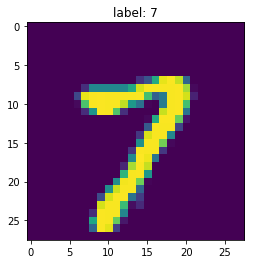

In [5]:
import random
idx = random.randint(0, len(y_train))
plt.imshow(x_train[idx])
plt.title('label: {}'.format(y_train[idx]))

In [6]:
imsize = x_train[idx].shape
classes, counts = np.unique(y_train, return_counts=True)
n_classes = len(classes)
print 'image size: {}, classes: {}, n_classes: {}'.format(imsize, classes, n_classes)

image size: (28, 28), classes: [0 1 2 3 4 5 6 7 8 9], n_classes: 10


Text(0.5,1,'Counts for each label')

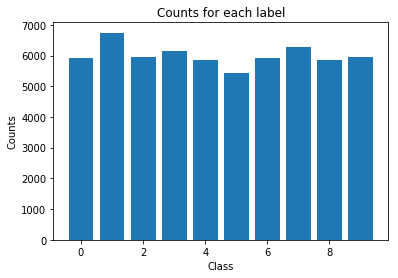

In [7]:
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.title('Counts for each label')

## Preprocessing
Preprocess each img into a binary feature map.

In [8]:
def convert_to_binary_featuremap(x_data, threshold=180):
    b_x_data = x_data > threshold
    return b_x_data

(60000, 28, 28) bool


Text(0.5,1,'binary img, label: 7')

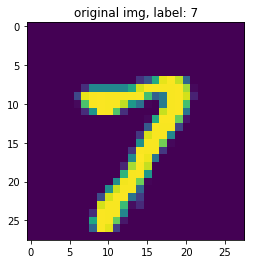

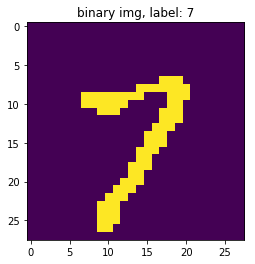

In [9]:
b_x_train = convert_to_binary_featuremap(x_train)
print b_x_train.shape, b_x_train.dtype
plt.figure(); plt.imshow(x_train[idx])
plt.title('original img, label: {}'.format(y_train[idx]))
plt.figure(); plt.imshow(b_x_train[idx])
plt.title('binary img, label: {}'.format(y_train[idx]))

In [10]:
b_x_test = convert_to_binary_featuremap(x_test)

## Training

Training: learn the 28x28 = 784 values of $P(x_i|C_k)$ for each of the 10 classes. Also compute $p(C_k)$. Overall, compute $784*10+1*10 = 7850$ floating point values.

To learn $p(x_i | C_k)$, we will do the following:
Across all imgs of the class $C_j$, for the i-th pixel, compute the probability the pixel is 1. This is the $p(x_i | C_k)$ for a particular i and k pair.
Do so for all i,k pairs.

To learn $p(C_k)$, just count up the number of imgs in class k, and divide by the total number of images. Do so for all classes.

In [11]:
prob_x_i_given_C_k = np.zeros((n_classes, imsize[0], imsize[1]))
prob_C_k = np.zeros((n_classes))

for k in classes:
    train_imgs_k = b_x_train[y_train == k]
    count_is_1_class = np.sum(train_imgs_k == 1, axis=0)
    prob_x_i_given_C_k[k] = count_is_1_class / float(train_imgs_k.shape[0])
    prob_C_k[k] = len(train_imgs_k) / float(len(x_train))

In [12]:
prob_C_k = counts / float(len(x_train))  # alternate defn.

In [13]:
prob_x_i_given_C_k.shape, prob_C_k.shape

((10, 28, 28), (10,))

Plot the feature map probability of a class k

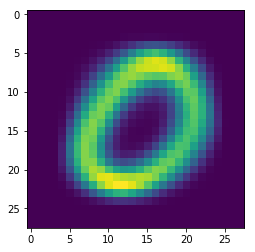

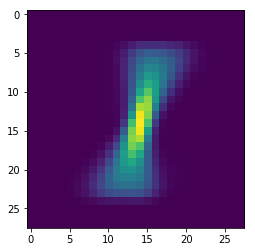

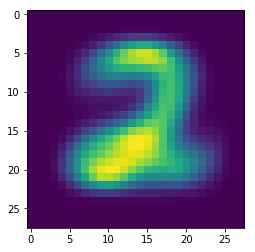

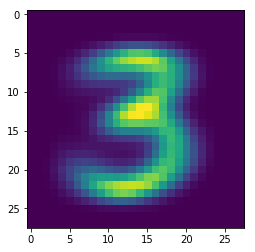

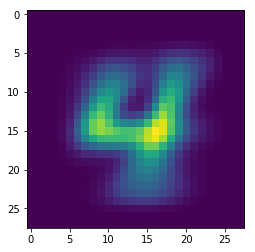

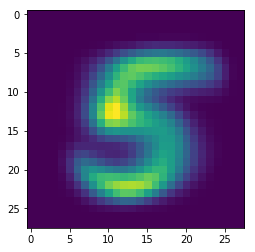

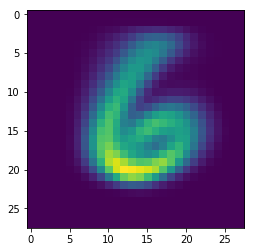

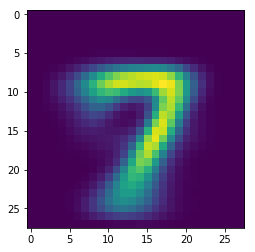

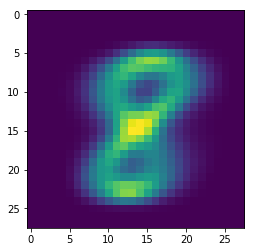

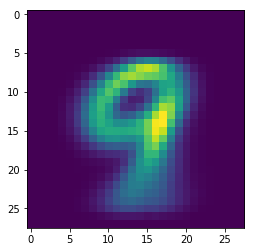

In [14]:
for k in classes:
    plt.figure()
    plt.imshow(prob_x_i_given_C_k[k,...] * prob_C_k[k])

## Testing

Inference is easy. Just do $ argmax_K (p(C_k) * \prod{p(x_i | C_k)})$

#### Evaluate on a single random img from the test set

Text(0.5,1,'label: 5')

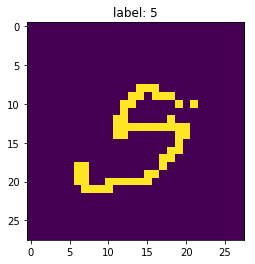

In [15]:
idx = random.randint(0, len(y_test))
img = b_x_test[idx]
label = y_test[idx]
plt.imshow(img); plt.title('label: {}'.format(label))

TODO: Think about a fast way to vectorize this computation.

In [16]:
def get_best_estimate(img, soft=False):
    """ Get the best class estimate of the img.
    If soft=True, get a vector with a normalized weight for each class."""
    results = np.zeros(n_classes, dtype=np.float64)
    for k in classes:
        # add a small value to avoid divide by zero errors
        oneprob = prob_x_i_given_C_k[k, img == 1] + np.finfo(np.float64).eps
        zeroprob = 1 - prob_x_i_given_C_k[k, img == 0]

        results[k] = np.sum(np.log(oneprob)) + np.sum(np.log(zeroprob)) + np.log(prob_C_k[k])

    if soft:
        results -= np.min(results) - 1
        results = results / np.max(results)
        return results
    return np.argmax(results)

soft_est = get_best_estimate(img, soft=True)
print 'best estimate (soft): {}'.format(np.argmax(soft_est))
print 'best estimate: {}'.format(get_best_estimate(img))

best estimate (soft): 5
best estimate: 5


#### Evalute on the whole test set

In [17]:
y_hat_test = np.asarray(map(get_best_estimate, b_x_test))
y_hat_test

array([7, 2, 1, ..., 9, 8, 6])

In [18]:
mismatches = np.count_nonzero(y_hat_test != y_test)
print 'Overall: {} / {} mis-inferences; {}% mis-inferences'.format(
    mismatches, len(y_test), mismatches / float(len(y_test)) * 100)

Overall: 1583 / 10000 mis-inferences; 15.83% mis-inferences


In [19]:
for k in classes:
    mismatches = len(y_hat_test[y_test == k] != k)
    print 'Class {}: {:4d} / {} mis-inferences; {:05.2f}% mis-inferences'.format(
        k, mismatches, len(y_test == k), mismatches / float(len(y_test == k)) * 100)

Class 0:  980 / 10000 mis-inferences; 09.80% mis-inferences
Class 1: 1135 / 10000 mis-inferences; 11.35% mis-inferences
Class 2: 1032 / 10000 mis-inferences; 10.32% mis-inferences
Class 3: 1010 / 10000 mis-inferences; 10.10% mis-inferences
Class 4:  982 / 10000 mis-inferences; 09.82% mis-inferences
Class 5:  892 / 10000 mis-inferences; 08.92% mis-inferences
Class 6:  958 / 10000 mis-inferences; 09.58% mis-inferences
Class 7: 1028 / 10000 mis-inferences; 10.28% mis-inferences
Class 8:  974 / 10000 mis-inferences; 09.74% mis-inferences
Class 9: 1009 / 10000 mis-inferences; 10.09% mis-inferences


Create a confusion matrix

In [20]:
confusion = np.zeros((n_classes, n_classes), dtype=np.int)
for true_class, inferred_class in zip(y_test, y_hat_test):
    confusion[true_class, inferred_class] += 1
confusion.shape

(10, 10)

Text(0.5,0,'inferred class')

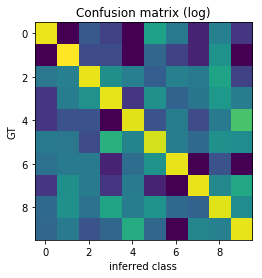

In [21]:
plt.imshow(np.log(confusion+1))
plt.title('Confusion matrix (log)')
plt.ylabel('GT')
plt.xlabel('inferred class')